# Fitting Dust Observations

This notebook is meant to provide the scaffolding for us to explore fitting 2-D and 3-D observations of dust, along with the associated observational effects that go along with it.

Each section of the notebook will be dedicated to a particular type of approach that we're interested in testing out.

# Problem Overview

The overarching goal of this project is to try to construct a function $f(\mathbf{x})$ as a function of (2-D or 3-D) position $\mathbf{x}$ that can serve as a good approximation to the underlying dust density field $\rho(\mathbf{x})$. Based on the input data set you'll be generating, this may be of the form

$$ f(\mathbf{x}) \approx \log \rho(\mathbf{x}) $$

in the simplest case,

$$ f(\mathbf{x}) \approx \rho(\mathbf{x}) $$

in the second-simplest case, and

$$ \frac{\partial g(\mathbf{x})}{\partial r} \equiv f(\mathbf{x}) \approx \rho(\mathbf{x})$$

in more realistic cases given $r \equiv ||\mathbf{x} - \mathbf{x}_0||$, where $\mathbf{x}_0$ is our current position.

In this last case, being able to redefine our model in terms of $\mathbf{x} \rightarrow (r, \boldsymbol{\theta})$, where $\boldsymbol{\theta}$ defines the angular position (in either polar or spherical coordinates), may be important to ensuring the behavior of the model as a function of $r$ can be treated differently than in $\boldsymbol{\theta}$. In addition, being able to analytically (rather than numerically) differentiate $g(\mathbf{x})$ would also be useful.

For the rest of the overview, I will assume that we're dealing with the most realistic case (i.e. fitting $g(\mathbf{x})$).

## Testing

We want to benchmark the ultimate performance of any method relative to the true underlying dust density field $\rho(\mathbf{x})$. Since the data we're using is simulated, we have access to these over a grid of positions $\mathbf{X}_{\rm grid} = \{ \mathbf{x}_i \}_{i=1}^{n_{\rm grid}}$ and corresponding dust density estimates $\mathbf{P}_{\rm grid} = \{ \rho_i \}_{i=1}^{n_{\rm grid}} = \{ \rho(\mathbf{x}_i) \}_{i=1}^{n_{\rm grid}}$. The choice of metrics (i.e. loss function or cost function) we will use to start will be the **square error (MSE)** evaluated over the grid in dust density

$$ C_{\rm lin}(\mathbf{X}_{\rm grid}, \mathbf{P}_{\rm grid}) = ||f(\mathbf{X}_{\rm grid}) - \mathbf{P}_{\rm grid}||^2 = \sum_{i=1}^{n_{\rm grid}} |f(\mathbf{x}_i) - \rho(\mathbf{x}_i)|^2 $$

An alternate metric that we will use will be computing the MSE after transforming the predictions using the **hyperbolic arcsine (arcsinh)** function:

$$ C_{\rm asinh}(\mathbf{X}_{\rm grid}, \mathbf{P}_{\rm grid}) = ||{\rm arcsinh}(f(\mathbf{X}_{\rm grid})) - {\rm arcsinh}(\mathbf{P}_{\rm grid})||^2 $$

This function is useful because at large values it behaves logarithmically while at small values it behaves linearly. This means the cost function is less sensitive to the deviations at larger values of $\rho(\mathbf{x})$ while behaving similarly for smaller values (and still permitting negative values, unlike a logarithm).

In practice, we won't have access to the underlying dust density with real data. Instead, we'll want to bechmark our performance using a hold-out **test set** of $\{ \mathbf{X}_{\rm test}, \mathbf{Y}_{\rm test} \}$, where $\mathbf{Y} = \{ \mathbf{y}_i \}_{i=1}^{n_{\rm test}}$ may not be tracing $\rho(\mathbf{x})$ directly. We'll then want to compare what the cost functions $C_{\rm lin}$ and $C_{\rm asinh}$ look like over both the underlying grid $\mathbf{P}_{\rm grid}$ and the observed test set $\mathbf{Y}_{\rm test}$. We will then try to understand what's going on if there are differences between the two.

## Training and Validation

The fitted function $f(\mathbf{x})$ will be derived using a collection of **training data** $\{ \mathbf{X}_{\rm train}, \mathbf{Y}_{\rm train} \}$ and **validation data** $\{ \mathbf{X}_{\rm valid}, \mathbf{Y}_{\rm valid} \}$. The latter will be useful for making sure that we don't overfit the training data. We will want to train our model using one of the specified cost functions above.

## Incorporating Errors

For more realistic data, we will have to deal with errors in both the measured positions $\mathbf{X}$ and the measured values $\mathbf{Y}$. These will give a corresponding set of noisy positions $\tilde{\mathbf{X}} = \{ \tilde{\mathbf{x}}_i \}$ and values $\tilde{\mathbf{Y}} = \{ \tilde{\mathbf{y}}_i \}$. The uncertainties that correspond to these noisy measurements 
are $\boldsymbol{\delta}=\{ \sigma_{r, i} \}$ in the $r$ direction (which translates to uncertainties in $\tilde{\mathbf{x}}_i$) and $\boldsymbol{\epsilon} = \{ \sigma_{y, i} \}$ for the individual $y_i$ values. These then define a set of **probability density functions (PDFs)** $P(\tilde{r}_i | r_i, \sigma_{r,i})$ and $P(\tilde{y}_i | y_i, \sigma_{y,i})$.

### Single Observation

Since we don't know what the true value actually is, the approach we want to take is to the **marginalize** over all possible values. In other words, we want to compute:

$$P(\tilde{\mathbf{x}}_i, \tilde{y}_i | \sigma_{r, i}, \sigma_{y,i}) = \int_{0}^{r} P(\tilde{y}_i | g(r \times \hat{\boldsymbol{\ell}}_i), \sigma_{y, i}) \, P(\tilde{r}_i | r \times \hat{\boldsymbol{\ell}}_i, \sigma_{r, i}) \,{\rm d}r$$

There are a couple things going on in this expression:
1. The integral over $r$ means that we want to explore all possible values of $r$ between $0$ and $\infty$. 
2. For each value of $r$, we compute how likely it is by evaluating the PDF $P(\tilde{r}_i| r, \sigma_{r, i})$. 
3. Each value of $r$ also corresponds to a given position $\mathbf{x} = r \times \hat{\boldsymbol{\ell}}_i$, where $\hat{\boldsymbol{\ell}}_i$ is the normal vector in the direction of the source $i$. 
4. This gives a prediction $g(\mathbf{x})$ from our fitted functional form.
5. We then evaluate the corresponding PDF $P(\tilde{y}_i | g(\mathbf{x}), \sigma_{y, i})$.

The end result is what's known as the **marginal probability**, which will increase as the function $g(\mathbf{x})$ becomes a better match to the underlying data. Evaluating this integral in a numerically feasible way will be a big part of the challenge incorporating errors into the predictions.

Note that in the case where we have no measurement uncertainty in $r$, this reduces to

$$P(\mathbf{x}_i, \tilde{y}_i | \sigma_{y,i}) = P(\tilde{y}_i | g(\mathbf{x}_i), \sigma_{y, i})$$

### Multiple Observations

Assuming each star provides an **independent and identically distributed (iid)** set of measurements (i.e. the results don't depend on how the stars are ordered and the observations are independent of each other), the probabilities across all the stars multiply and so we get a total probability of

$$ P(\tilde{\mathbf{X}}, \tilde{\mathbf{Y}} | \boldsymbol{\delta}, \boldsymbol{\epsilon}) = \prod_{i=1}^{n} P(\tilde{\mathbf{x}}_i, \tilde{y}_i | \sigma_{r, i}, \sigma_{y,i}) $$

Most often, it is computationally much easier to deal with the log-probabilities

$$ \log P(\tilde{\mathbf{X}}, \tilde{\mathbf{Y}} | \boldsymbol{\delta}, \boldsymbol{\epsilon}) = \sum_{i=1}^{n} \log P(\tilde{\mathbf{x}}_i, \tilde{y}_i | \sigma_{r, i}, \sigma_{y,i}) $$

This looks somewhat similar to our cost function, and indeed there is a deep connection here between the log-probability of our probabilistic model and the cost function of our original (error-less) model. To make things explicit, we will define a new cost function:

$$ \tilde{C}_{\rm lin}(\tilde{\mathbf{X}}, \tilde{\mathbf{Y}} | \boldsymbol{\delta}, \boldsymbol{\epsilon}) = \log P(\tilde{\mathbf{X}}, \tilde{\mathbf{Y}} | \boldsymbol{\delta}, \boldsymbol{\epsilon}) = \sum_{i=1}^{n} \log \left( \int_{0}^{r} P(\tilde{y}_i | g(r \times \hat{\boldsymbol{\ell}}_i), \sigma_{y, i}) \, P(\tilde{r}_i | r \times \hat{\boldsymbol{\ell}}_i, \sigma_{r, i}) \,{\rm d}r \right) $$

The associated function $\tilde{C}_{\rm asinh}$ is defined analagous to the previous case, where we apply the hyperbolic arcsine transformation to modify our predictions $g(\mathbf{x})$ and the associated observations $\tilde{\mathbf{Y}}$ and errors $\boldsymbol{\delta}$.

Again, in the case where we have no measurement uncertainty in $r$, the integral goes away and this reduces to

$$ \tilde{C}_{\rm lin}(\mathbf{X}, \tilde{\mathbf{Y}} | \boldsymbol{\epsilon}) = \log P(\mathbf{X}, \tilde{\mathbf{Y}} | \boldsymbol{\epsilon}) = \sum_{i=1}^{n} \log P(\tilde{y}_i | g(\mathbf{x}_i), \sigma_{y, i}) $$

For Gaussian errors (such as the ones we assume), you'll find this expression ends up looking *very* similar to our original cost function.

## Summary

To fit the simulated data, you will need to:
1. Define the cost function(s) based on some of the considerations above.
2. Load in the training, validation, and testing data.
3. Initialize our model.
4. Fit the model to the training data, using the validation data to tune additional hyper-parameters of the model if necessary.
5. Evaluate the cost function(s) for our best-fit model over the test data and the underlying grid of points. (This may involve differentiating the model.)

# Preamble

In [1]:
from imports import *
from loss_functions import *
from loading_data import *
from general_plotting_and_model_prediction import *
from fixed_bins import * 
from interpolation import *
from neural_network import * 
# plot in-line within the notebook
%matplotlib inline 

### Real vs Noisy data plots

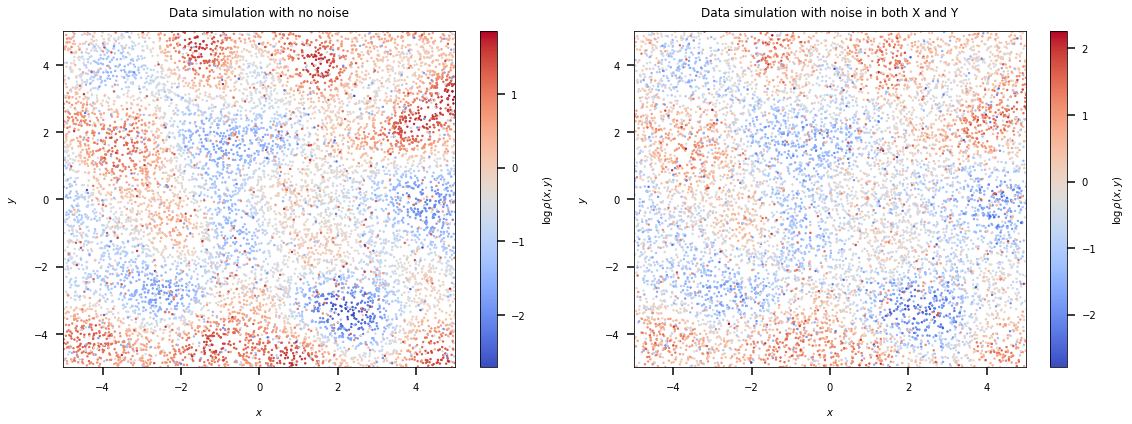

In [2]:
plot_noisy_vs_real_data() #!!! plot noisy with X error, noisy with Y error, noisy with both errors, and noisy without either

# Model 1: Fixed Bins

The simplest model we want to benchmark is the **fixed bin** model. This makes the approximation that we can divide up our area into a few quadrants and that within each quadrant the value of $f(\mathbf{x}) \approx \rho(\mathbf{x})$ is constant. These quadrants can either be in Euclidean $(x, y)$ or polar $(r, \theta)$ coordinates (both have been used in the literature).

### Sample 50 Bin Model

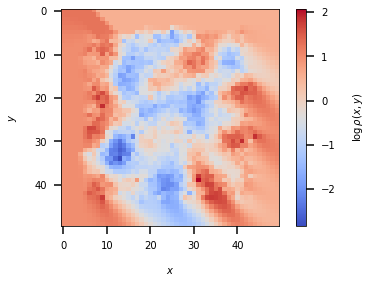

In [3]:
# sample bin model with 50 bins
fig, ax = plt.subplots()
img = ax.imshow(get_bin_model(50), cmap='coolwarm')
fig.colorbar(img, label=r'$\log \rho(x, y)$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

### Sample Loss vs Number of Bins and 3 Panel plot for 100 bins model

In [4]:
# how loss changes as function of bins
bin_model_lst, loss_lin_vals, loss_asinh_vals = plot_loss_bin_model(1, 100, Xo_samp_test, Yo_test, error = True)
# bin_model_lst, loss_lin_vals, loss_asinh_vals = plot_loss_bin_model(1, 100, Xo_samp_test, Yo_test, error = True)
bin_model = bin_model_lst[15] #bin model with 15 bins

KeyboardInterrupt: 

<Figure size 288x288 with 0 Axes>

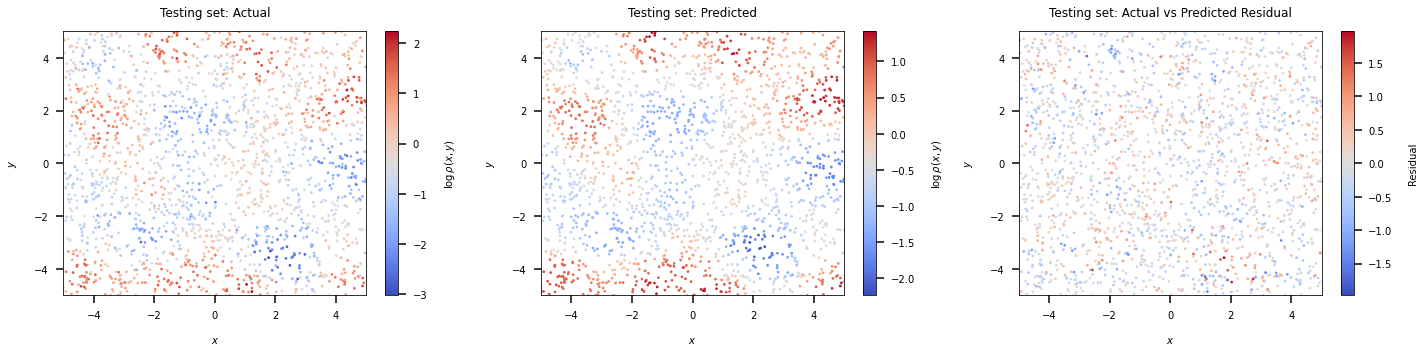

In [5]:
plot_map_panels(Xo_samp_test, Yo_test, 'bin', bin_model)

### Comparing Bin Models from 1 to 100 Bins

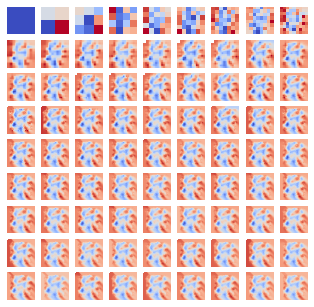

In [6]:
## all bin models generated from 1 to 100 bins
fig = plt.figure(figsize=(6, 6))
nrows = 10
ncols = 10
axes = [fig.add_subplot(nrows, ncols, r * ncols + c) for r in range(1, nrows) for c in range(1, ncols)]
for i,ax in enumerate(axes):
    img = ax.imshow(bin_model_lst[i], cmap='coolwarm')
# remove the x and y ticks
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
plt.savefig(r'plots/bins-100.png')

### Finding Expected Loss using error bars (comparable with graph above)

The floor for loss graph above is the error we expect. Every datapoint is perturbed by (0.9 - 0.1)/2 = 0.4 on average. Then when squaring that, the expected linear loss for any datapoint is 0.4**2 = 0.16. So the total loss is 0.16 * num datapoints = 0.16 * 2000 = 320
np.sum(np.square(error_bar)) is the loss we expect if getting perfect predictions. 

In [5]:
print(np.sum(np.square(Ye_test))) # loss we expect if getting perfect predictions? 
print(np.sum(np.square(np.arcsinh(Ye_test)))) 

186.7404124054798
180.50793459118557


# Model 2: Interpolation

We used **smooth interpolation** to generate our data in the first place (based on our underlying **Gaussian Process (GP)** model), so we can also try and derive our estimate for $g(\mathbf{x})$ using the same overall approach. There is also a [TensorFlow implementation](https://www.tensorflow.org/addons/api_docs/python/tfa/image/interpolate_spline) that might be useful as we start modifying the loss function.

### Predictions vs True values for smooth = 0

In [6]:
# sample using interpolation: one example
logdust = interpolate.Rbf(Xo_train[:, 0], Xo_train[:, 1], Yo_train, 
                          function='quintic',  # specific interpolation method
                          smooth=0)  # smoothing parameter (0=exact fit)
# evaluate positions log dust densities
train_pred = logdust(Xo_train[:, 0], Xo_train[:, 1])
val_pred = logdust(Xo_valid[:, 0], Xo_valid[:, 1])  # intrinsic values
test_pred = logdust(Xo_test[:, 0], Xo_test[:, 1]) 

loss_lin_train, loss_asinh_train = loss_lin_np(Yo_train, train_pred), loss_asinh_np(Yo_train, train_pred)
loss_lin_val, loss_asinh_val = loss_lin_np(Yo_valid, val_pred), loss_asinh_np(Yo_valid, val_pred)
loss_lin_test, loss_asinh_test = loss_lin_np(Yo_test, test_pred), loss_asinh_np(Yo_test, test_pred)

/home/ava/.local/lib/python3.8/site-packages/scipy/interpolate/rbf.py:257: LinAlgWarning: Ill-conditioned matrix (rcond=5.21486e-18): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)


lin train, val, test loss: 0.43637438557240826 5480.962923351418 4637.07628799213
asinh train, val, test loss: 0.27628246815504665 1461.6840579253922 1454.9684426392769


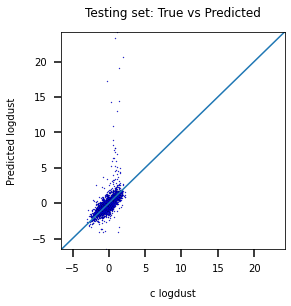

In [7]:
print('lin train, val, test loss: ' + repr(loss_lin_train), repr(loss_lin_val), repr(loss_lin_test))
print('asinh train, val, test loss: ' + repr(loss_asinh_train), repr(loss_asinh_val), repr(loss_asinh_test))
plt.figure(figsize=(4, 4))
plot_pred_vs_true(Xo_samp_test, Yo_test, 'interpolate', logdust, title = 'Testing set: True vs Predicted')

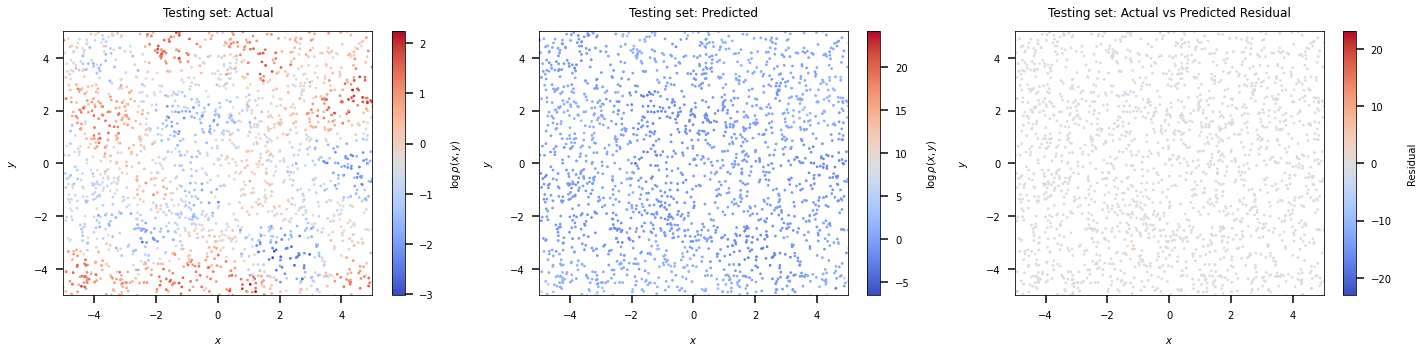

In [8]:
plot_map_panels(Xo_samp_test, Yo_test, 'interpolate', logdust)

### Loss vs Smooth metric

2000 2000 10


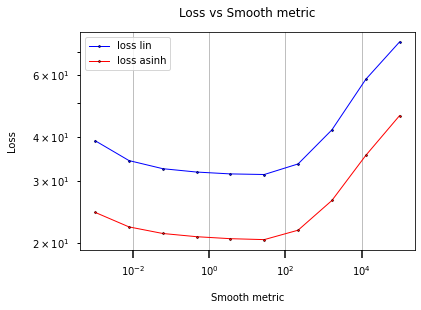

In [9]:
print(len(Xo_samp_test), len(Yo_test), len(Xo_samp_test[0]))
plot_interpolate_loss(Xo_samp_test, Yo_test)

# Model 3: Neural Network

**Neural networks (NNs)** are really useful at constructing smooth functions to fit complex datasets, and so are also something we also want to explore here. In addition, there is actually a [deep connection](https://arxiv.org/pdf/1711.00165.pdf) between NNs and GPs, where you can show that an infinitely wide NN is equivalent to a GP with a particular kernel. Since our data were generated using a GP, it therefore makes sense to try and fit a (wide) neural network to the data.

(There is also [more recent work](https://arxiv.org/pdf/1912.02803.pdf) in this area since things have moved quickly over the last few years, so we might even be able to explore even more cutting-edge implementations such as "infinite-width" networks if time permits.)

### Train and make Predictions NN

In [2]:
# I just pasted the imports here too to avoid going to the top and running this piece over and over, I will delete after the NN works
from imports import *
from loss_functions import *
from loading_data import *
from general_plotting_and_model_prediction import *
from fixed_bins import * 
from interpolation import *
from neural_network import * 
# plot in-line within the notebook
%matplotlib inline 

In [4]:
train_loss, val_loss = get_NN_model()


Start of epoch 0
Training loss (for one batch) at step 0: 11.4776
Seen so far: 100 samples
Training loss (for one batch) at step 10: 12.5964
Seen so far: 1100 samples
Training loss (for one batch) at step 20: 9.6982
Seen so far: 2100 samples
Training loss (for one batch) at step 30: 13.4471
Seen so far: 3100 samples
Training loss (for one batch) at step 40: 12.5396
Seen so far: 4100 samples
Training loss (for one batch) at step 50: 8.7953
Seen so far: 5100 samples

Start of epoch 1
Training loss (for one batch) at step 0: 14.0510
Seen so far: 100 samples
Training loss (for one batch) at step 10: 9.7450
Seen so far: 1100 samples
Training loss (for one batch) at step 20: 8.8863
Seen so far: 2100 samples
Training loss (for one batch) at step 30: 12.9811
Seen so far: 3100 samples
Training loss (for one batch) at step 40: 12.4517
Seen so far: 4100 samples
Training loss (for one batch) at step 50: 9.7437
Seen so far: 5100 samples


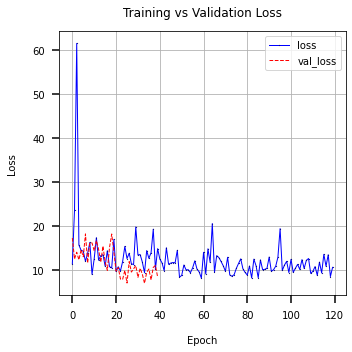

In [6]:
plt.figure(figsize=(5, 5)) 
# plt.subplot(1, 2, 1)
plot_NN_loss(train_loss, val_loss)
# plt.subplot(1, 2, 2)
# plot_pred_vs_true(train_loss, val_loss,model_costlin, color = 'red', title = 'Testing set: True vs Predicted - MSE loss')
# plt.subplot(1, 3, 3)
# plot_pred_vs_true(Xo_test, Yo_test, 'NN' ,model_costasinh, color = 'blue', title = 'Testing set: True vs Predicted - arcsinh loss')
plt.tight_layout()

TypeError: get_NN_model() takes 0 positional arguments but 6 were given

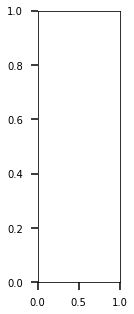

In [2]:
plt.figure(figsize=(5, 5)) 
plt.subplot(1, 3, 1)
model_costlin = get_NN_model('lin', None,  reluAct,  'loss costlin', 'val_loss costlin', 'red')
model_costasinh = get_NN_model('asinh', None,  reluAct,  'loss asinh', 'val_loss asinh', 'blue')
plt.subplot(1, 3, 2)
plot_pred_vs_true(Xo_test, Yo_test,'NN', model_costlin, color = 'red', title = 'Testing set: True vs Predicted - MSE loss')
plt.subplot(1, 3, 3)
plot_pred_vs_true(Xo_test, Yo_test, 'NN' ,model_costasinh, color = 'blue', title = 'Testing set: True vs Predicted - arcsinh loss')
plt.tight_layout()

In [ ]:
plt.figure(figsize=(8, 4)) 
plt.subplot(1, 2, 1)
# model_costlin = get_NN_model('lin', None,  reluAct,  'loss costlin', 'val_loss costlin', 'red', [0.0,0.5], error = True)
# model_costasinh = get_NN_model('asinh', None,  reluAct,  'loss asinh', 'val_loss asinh', 'blue', [0.0,0.4], error = True)
plot_pred_vs_true(Xo_test, Y_test,'NN', model_costlin, color = 'red', title = 'Testing set: True vs Predicted - lin loss')
plt.subplot(1, 2, 2)
plot_pred_vs_true(Xo_test, Y_test, 'NN' ,model_costasinh, color = 'blue', title = 'Testing set: True vs Predicted - asinh loss')
plt.tight_layout()
plt.savefig('predictedtrueNN.png')

### Retraining NN

In [ ]:
# train for longer
# model.save('partly_trained.h5')
# del model
#Reload model
# model = load_model('partly_trained.h5')

history_costlin = model_costlin.fit(Xo_train, Yo_train, epochs=200, verbose=0,batch_size = BATCH_SIZE, validation_data = (Xo_valid, Yo_valid),)
# history_costasinh = model_costasinh.fit(Xo_train, Yo_train, epochs=200, verbose=0, batch_size = BATCH_SIZE, validation_data = (Xo_valid, Yo_valid),)
plt.figure(figsize=(8, 4)) 
plt.subplot(1, 2, 1)
plot_pred_vs_true(Xo_test, Yo_test,'NN', model_costlin, color = 'red', title = 'Testing set: True vs Predicted - MSE loss')
plt.subplot(1, 2, 2)
plot_pred_vs_true(Xo_test, Yo_test,'NN',model_costasinh, color = 'blue', title = 'Testing set: True vs Predicted - arcsinh loss')
plt.tight_layout()

hist_costlin = pd.DataFrame(history_costlin.history)
hist_costlin['epoch'] = history_costlin.epoch
print(hist_costlin.tail())
hist_costasinh = pd.DataFrame(history_costasinh.history)
hist_costasinh['epoch'] = history_costasinh.epoch
print(hist_costasinh.tail())

In [ ]:
plt.figure(figsize=(16, 4))
plot_map_panels(Xo_test, Yo_test, 'NN', model_costlin)
# plt.figure(figsize=(16, 4))
# plot_map_panels(Xo_test, Yo_test, 'NN', model_costasinh)

# Model 4: Partially Monotone Neural Network

**Partially monotone neural networks (PMNNs)** enforce a monotonicity (i.e. non-negative gradient) constraint on $\geq 1$ of the inputs to the network. In this case, we want to use this ability to enforce monotonicity in $g(\mathbf{x})$ in the radial direction (i.e. as a function of $r$) but not in the angular direction. This can be done by forcing the weights associated with the monotonic parameter to always be non-negative and ensuring that the activation functions used also are non-negative. This can also be accompanied by changes to the network architecture

In [ ]:
# define and fit partially monotone neural network